<a href="https://colab.research.google.com/github/mra49/Capstone/blob/main/SalesForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Capstone/df_postUnify_PreRFM.csv")

<ipython-input-3-8ce247786829>:1: DtypeWarning: Columns (5,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/Capstone/df_postUnify_PreRFM.csv")


In [4]:
# Convert 'Document Date' to datetime and sort
df['Document Date'] = pd.to_datetime(df['Document Date'], errors='coerce')
df = df.sort_values(by='Document Date')


In [5]:
# Data types and missing values
data_types_missing = df.dtypes.to_frame(name='Data Type').join(df.isnull().sum().rename('Missing Value Proportion'))
print(data_types_missing)


                         Data Type  Missing Value Proportion
Location                    object                     12363
Brand                       object                         0
SubBrand                    object                         0
Category                    object                      2592
SOP Number                  object                         0
Item Number                 object                         0
Item Description            object                         0
QTY                          int64                         0
Unit Price                 float64                         0
Extended Price             float64                         0
Customer Number             object                         0
Document Date       datetime64[ns]                         0
Location Code               object                         0
Item Short Name             object                         0
Customer Name               object                         0
SOP Type                

In [6]:
# Statistical summary
statistical_summary = df.describe(include='all', datetime_is_numeric=True)
print(statistical_summary)

       Location   Brand SubBrand       Category         SOP Number  \
count     91216  103579   103579         100987             103579   
unique        7      53       80             20              18383   
top       zone1   style    foamy  Personal Care  inv00000000007055   
freq      42010   42013    39295          56054                 56   
mean        NaN     NaN      NaN            NaN                NaN   
min         NaN     NaN      NaN            NaN                NaN   
25%         NaN     NaN      NaN            NaN                NaN   
50%         NaN     NaN      NaN            NaN                NaN   
75%         NaN     NaN      NaN            NaN                NaN   
max         NaN     NaN      NaN            NaN                NaN   
std         NaN     NaN      NaN            NaN                NaN   

        Item Number       Item Description            QTY     Unit Price  \
count      103579.0                 103579  103579.000000  103579.000000   
unique 

In [7]:
zero_qty_shampoo = df[(df['product_type'] == 'shampoo') & (df['QTY'] == 0)]

if zero_qty_shampoo.empty:
    print("There are no 0 values in 'QTY' for 'shampoo' product_type.")
else:
    print("There are 0 values in 'QTY' for 'shampoo' product_type.")

There are no 0 values in 'QTY' for 'shampoo' product_type.


In [8]:
# Aggregate data by date
daily_data = df.groupby(df['Document Date'].dt.date)['QTY'].sum().reset_index()

In [9]:
import pandas as pd

# Assuming daily_data is your DataFrame

# Convert 'Document Date' to datetime format
daily_data['Document Date'] = pd.to_datetime(daily_data['Document Date'], errors='coerce')

# Now you can extract the day, month, and year
daily_data['Day'] = daily_data['Document Date'].dt.day
daily_data['Month'] = daily_data['Document Date'].dt.month
daily_data['Year'] = daily_data['Document Date'].dt.year

# Verify the changes
print(daily_data[['Document Date', 'Day', 'Month', 'Year']].head())


  Document Date  Day  Month  Year
0    2020-01-02    2      1  2020
1    2020-01-03    3      1  2020
2    2020-01-04    4      1  2020
3    2020-01-06    6      1  2020
4    2020-01-07    7      1  2020


In [10]:
# Group by 'product_type' and sum 'QTY'
product_type_qty = df.groupby('product_type')['QTY'].sum().reset_index()

# Sort the results for better readability (optional)
product_type_qty = product_type_qty.sort_values(by='QTY', ascending=False)

# Display the result
print(product_type_qty)


         product_type     QTY
184           shampoo  646744
66        dishwashing  335826
130       laundry gel  110892
88    general cleaner   81867
118         hand soap   64482
..                ...     ...
81   fascinelle spray       1
134      lith clipper       1
132              lift       1
39              brush       1
46             coffee       1

[226 rows x 2 columns]


In [11]:
import pandas as pd

# Assuming data is your DataFrame

# Calculate total sales per product
total_sales_per_product = df.groupby('product_type')['Extended Price'].sum().reset_index()

# Calculate total sales of all products
total_sales_all_products = total_sales_per_product['Extended Price'].sum()

# Calculate proportion of each product's sales
total_sales_per_product['Sales Proportion'] = total_sales_per_product['Extended Price'] / total_sales_all_products

# Sort the results by 'Extended Price' in descending order
total_sales_per_product = total_sales_per_product.sort_values(by='Extended Price', ascending=False)

# Display the result
print(total_sales_per_product.head(15))


              product_type  Extended Price  Sales Proportion
184                shampoo    1.497706e+07          0.464375
66             dishwashing    6.338873e+06          0.196541
130            laundry gel    3.240409e+06          0.100471
88         general cleaner    1.456768e+06          0.045168
118              hand soap    1.289726e+06          0.039989
77          fabric softner    1.146069e+06          0.035535
67            disinfectant    9.795285e+05          0.030371
152      multi-use shampoo    7.068399e+05          0.021916
83           floor cleaner    6.227723e+05          0.019310
90           glass cleaner    1.625372e+05          0.005040
188             shower gel    1.306650e+05          0.004051
9    anti-dandruff shampoo    8.741831e+04          0.002710
13              antiseptic    8.474707e+04          0.002628
4                  alcohol    8.353710e+04          0.002590
17            baby shampoo    7.019463e+04          0.002176


In [12]:
import pandas as pd

# Assuming data is your DataFrame

# List of brands for which the product_scent should be 'Not Applicable'
non_scent_brands = ['remington', 'wahl', 'babyliss', 'vitality']

# Replace 'product_scent' with 'Not Applicable' for these brands
df.loc[df['Brand'].str.lower().isin(non_scent_brands), 'product_scent'] = 'Not Applicable'

# Display some of the data to verify the changes
print(df[['Brand', 'product_scent']].head())


        Brand   product_scent
0   remington  Not Applicable
61      style      cool ocean
60      style             NaN
59      style             NaN
58      style             NaN


In [13]:
# Data types and missing values
data_types_missing = df.dtypes.to_frame(name='Data Type').join(df.isnull().sum().rename('Missing Value Proportion'))
print(data_types_missing)


                         Data Type  Missing Value Proportion
Location                    object                     12363
Brand                       object                         0
SubBrand                    object                         0
Category                    object                      2592
SOP Number                  object                         0
Item Number                 object                         0
Item Description            object                         0
QTY                          int64                         0
Unit Price                 float64                         0
Extended Price             float64                         0
Customer Number             object                         0
Document Date       datetime64[ns]                         0
Location Code               object                         0
Item Short Name             object                         0
Customer Name               object                         0
SOP Type                

###Add neutral to scentless shampoo's

In [14]:
import pandas as pd

# Assuming df is your DataFrame

# Filter to select rows where 'product_type' is 'shampoo' and 'product_scent' is null
shampoo_with_null_scent = df[(df['product_type'] == 'shampoo') & (df['product_scent'].isnull())]

# Get the count of these rows
count_shampoo_with_null_scent = len(shampoo_with_null_scent)

# Display the count
print("Count of shampoo products with null scent:", count_shampoo_with_null_scent)


Count of shampoo products with null scent: 3717


In [15]:
# Replace null values in 'product_scent' with 'Neutral' for 'shampoo' product_type
df.loc[(df['product_type'] == 'shampoo') & (df['product_scent'].isnull()), 'product_scent'] = 'Neutral'

# Verify the changes (optional)
print(df[df['product_type'] == 'shampoo'][['product_type', 'product_scent']].head())

   product_type product_scent
61      shampoo    cool ocean
60      shampoo       Neutral
59      shampoo       Neutral
57      shampoo       Neutral
62      shampoo     m.islands


###Replace Item Number values with those in Unified IN and delete the latter

In [16]:
import pandas as pd

# Assuming df is your DataFrame

# Replace 'Item Number' with values from 'Unique IN'
df['Item Number'] = df['Unified IN']

# Drop the 'Unique IN' column
df.drop(columns=['Unified IN'], inplace=True)

# Drop columns with no variation
for column in df.columns:
    if df[column].nunique() == 1:
        df.drop(columns=[column], inplace=True)

In [17]:
###########  Genral Cleaning   ############
# Update 'With Offer' based on 'Item Description' containing '+' or '*'
df['With Offer'] = df['Item Description'].apply(lambda x: 1 if ('+' in x or '*' in x) else 0)

# Verify the changes (optional)
print(df[['Item Description', 'With Offer']].head())

                  Item Description  With Offer
0   rem s1a100 my stylist straight           0
61   style cool ocean shampoo 2250           0
60          style shanpoo 1.125l*3           1
59          style shanpoo 1.125l*3           1
58  style bone marrow conditioning           0


In [18]:
# Count the occurrences of each value in the 'With Offer' column
offer_counts = df['With Offer'].value_counts()

# Display the counts
print(offer_counts)

0    98460
1     5119
Name: With Offer, dtype: int64


In [19]:
import pandas as pd
import re

# Assuming df is your DataFrame

# Function to convert and standardize product size
def standardize_product_size(size):
    # Convert to string, handle None, and strip whitespace
    size_str = str(size).strip() if size is not None else ''

    # # Debug: Print the original size string
    # print("Original:", size_str)

    # Extract numeric part and unit
    numeric_part = re.sub('[^0-9.]', '', size_str)
    unit = re.sub('[0-9.]', '', size_str).lower()

    # Convert the numeric part to float
    numeric_size = float(numeric_part) if numeric_part else 0

    # Convert 'ml' or 'm' to liters
    if 'ml' in unit or 'm' in unit:
        result = f"{numeric_size / 1000}L"
    elif 'l' in unit:
        result = f"{numeric_size}L"
    elif unit == '' and numeric_size > 12:
        result = f"{numeric_size / 1000}L"
    elif unit == '':
        result = f"{numeric_size}L"
    else:
        result = f"{numeric_size}{unit}"

    # # Debug: Print the final result
    # print("Converted:", result)

    return result

# Apply the function to the 'product_size' column
df['product_size'] = df['product_size'].apply(standardize_product_size)

# Verify the changes
print(df[['Item Description', 'product_size']].head(5))


                  Item Description product_size
0   rem s1a100 my stylist straight         0nan
61   style cool ocean shampoo 2250        2.25L
60          style shanpoo 1.125l*3         3.0L
59          style shanpoo 1.125l*3         3.0L
58  style bone marrow conditioning         0nan


In [20]:
df['product_size'] = df['product_size'].replace('0.0nan', np.nan)

In [21]:
# Group by 'Item Number' and filter out those that appear less than 10 times, then overwrite df
df = df.groupby('Item Number').filter(lambda x: len(x) >= 10)

In [22]:
import pandas as pd

# Assuming df is your DataFrame

# Filter the DataFrame for 'shampoo' product_type
shampoo_df = df[df['product_type'] == 'shampoo']

# Count the missing 'product_size' values
missing_sizes_count = shampoo_df['product_size'].isnull().sum()
missing_location_count = shampoo_df['Location ID'].isnull().sum()
# Display the count
print(f"Number of missing size values for shampoo product_type: {missing_sizes_count}")
print(f"Number of missing size values for shampoo product_type: {missing_location_count}")

Number of missing size values for shampoo product_type: 0
Number of missing size values for shampoo product_type: 5458


In [23]:
distinct_sizes = shampoo_df['product_size'].unique()

print("Distinct product sizes for 'shampoo':", distinct_sizes)

Distinct product sizes for 'shampoo': ['2.25L' '3.0L' '0.5L' '0.022L' '4.0L' '0nan' '6.0L' '1.125L' '1.5L'
 '2.2L' '2.0L' '1.0L' '1.1L' '10.0L' '0.008L' '4.2L' '0.225L' '11.0L'
 '0.112L' '0.4L' '0.04L']


In [24]:
size_mapping = {
    "1.125L": ['0.0112L',''],
    "10L": 'Medium',
    3: 'Large'
}

# Replace numeric size values with custom values using the dictionary
df['product_size'] = df['product_size'].map(size_mapping)

# Display the updated DataFrame
print(df)

       Location   Brand    SubBrand            Category         SOP Number  \
61        zone1   style    sh2250+s       Personal Care  inv00000000005717   
60        zone1   style    sh1125+s       Personal Care  inv00000000005717   
59        zone1   style    sh1125+s       Personal Care  inv00000000005717   
58        zone1   style       style       Personal Care  inv00000000005716   
57        zone1  Keplex  profession       Personal Care  inv00000000005716   
...         ...     ...         ...                 ...                ...   
103514    zone3   style    sh2250+s       Personal Care  inv00000000025343   
103513    zone1   foamy       foamy  Household Cleaning  inv00000000025342   
103512    zone1   foamy       foamy  Household Cleaning  inv00000000025342   
103510    zone1   foamy       foamy  Household Cleaning  inv00000000025342   
103578    zone3   foamy       foamy  Household Cleaning  inv00000000025353   

       Item Number                Item Description  QTY  Unit P

In [25]:
shampoo_df.dtypes

Location                      object
Brand                         object
SubBrand                      object
Category                      object
SOP Number                    object
Item Number                   object
Item Description              object
QTY                            int64
Unit Price                   float64
Extended Price               float64
Customer Number               object
Document Date         datetime64[ns]
Item Short Name               object
Customer Name                 object
Location ID                   object
Offer Status                  object
product_type                  object
product_scent                 object
product_size                  object
Description Length             int64
Subcategory                   object
With Offer                     int64
Day                            int64
Month                          int64
Year                           int64
dtype: object

The plan is to create a reference DataFrame that maps each unique customer number to its corresponding location (using the first location that appears for each customer number). Then, we will use this mapping to fill in missing location values in your original DataFrame.

In [26]:
import pandas as pd

# Assuming df is your original DataFrame

# Create a reference DataFrame with unique customer numbers and their first corresponding location
ref_df = df.dropna(subset=['Location ID', 'Customer Number'])\
           .drop_duplicates(subset='Customer Number')\
           [['Customer Number', 'Location ID']]

print(ref_df.head())  # Just to check the reference DataFrame

   Customer Number   Location ID
61      000c004280      Nabatieh
58      000c000007  intercompany
84      000c029866         Beqaa
76      000c025095        slska1
18      000c023682         South


In [27]:
# Function to fill missing locations based on the customer number
def fill_missing_location(row):
    if pd.isna(row['Location ID']) and row['Customer Number'] in ref_df['Customer Number'].values:
        return ref_df[ref_df['Customer Number'] == row['Customer Number']]['Location ID'].values[0]
    else:
        return row['Location ID']

# Apply the function to fill missing 'Location ID'
df['Location ID'] = df.apply(fill_missing_location, axis=1)

In [28]:
missing_location_count = shampoo_df['Location ID'].isnull().sum()
print(f"Number of missing size values for shampoo product_type: {missing_location_count}")

Number of missing size values for shampoo product_type: 5458


Checking for Outliers

In [29]:
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, outliers.shape[0], outliers.describe()

In [30]:
# Assuming df is your DataFrame and 'QTY' is the column you want to check
outliers_qty, count_qty, description_qty = detect_outliers_iqr(shampoo_df, 'QTY')

# Display the count and summary of outliers
print(f"Count of Outliers in QTY: {count_qty}")
print("Outlier Summary for QTY:")
print(description_qty)

Count of Outliers in QTY: 5558
Outlier Summary for QTY:
               QTY   Unit Price  Extended Price  Description Length  \
count  5558.000000  5558.000000     5558.000000         5558.000000   
mean     67.362540    21.427383     1196.532297           29.785894   
std      51.856637    23.083175     1117.228412            3.465639   
min      26.000000     0.000000        0.000000           21.000000   
25%      36.000000     8.226000      432.000000           29.000000   
50%      48.000000    15.337000      843.780000           30.000000   
75%      80.000000    23.620000     1637.319000           30.000000   
max     336.000000   162.839000     4915.404000           41.000000   

        With Offer          Day        Month         Year  
count  5558.000000  5558.000000  5558.000000  5558.000000  
mean      0.025369    18.594818     6.645916  2020.901223  
std       0.157257     8.930555     3.542263     0.919347  
min       0.000000     1.000000     1.000000  2020.000000  
25% 

checking for extreme outliers

In [31]:
def detect_extreme_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 30 * IQR

    extreme_outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return extreme_outliers

In [32]:
# Assuming df is your DataFrame and 'QTY' is the column you want to check
extreme_outliers_qty = detect_extreme_outliers_iqr(shampoo_df, 'QTY')

# Sort the extreme outliers by 'QTY'
extreme_outliers_qty_sorted = extreme_outliers_qty.sort_values(by='QTY')

# Display only the 'QTY' and 'Item Description' columns
print(extreme_outliers_qty_sorted[['Item Description', 'QTY']])

                            Item Description  QTY
10216         reflet argent gris nacre shamp  285
3989                  x-pert shampoo rose 6l  300
29884         style shampoo alpine herbs 225  300
25680   style shampoo meridian island 2250ml  300
25685             style sh cool ocean 1.125l  300
...                                      ...  ...
100278        style shampoo cool ocean 2250m  300
13576             style sh cool ocean 1.125l  336
4547          style shampoo meridian 1.125+s  336
4546                   style shampoo1.125l*2  336
13594             style sh cool ocean 1.125l  336

[68 rows x 2 columns]


In [33]:
# Check for missing values in the relevant columns for ARIMA
missing_values_qty = df['QTY'].isnull().sum()
missing_values_date = df['Document Date'].isnull().sum()

# Display the counts of missing values
print(f"Missing Values in 'QTY': {missing_values_qty}")
print(f"Missing Values in 'Document Date': {missing_values_date}")

Missing Values in 'QTY': 0
Missing Values in 'Document Date': 0


In [34]:
shampoo_daily = shampoo_df.groupby(shampoo_df['Document Date'].dt.date)['QTY'].sum()

In [35]:
shampoo_daily.index = pd.to_datetime(shampoo_daily.index)
shampoo_daily = shampoo_daily.sort_index()

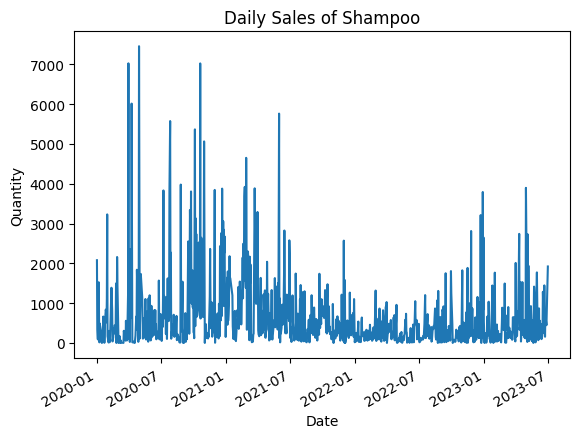

In [36]:
import matplotlib.pyplot as plt

shampoo_daily.plot()
plt.title('Daily Sales of Shampoo')
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.show()

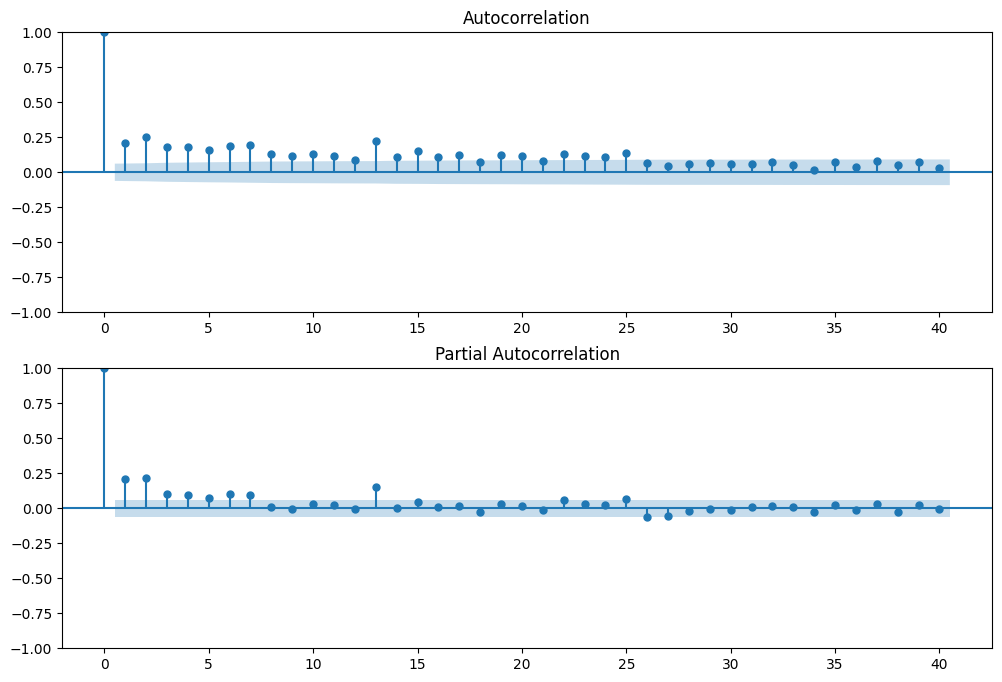

In [37]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming shampoo_daily is your original time series
# Plot the ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))

# ACF plot
plot_acf(shampoo_daily, lags=40, ax=ax1)  # Adjust lags as necessary

# PACF plot
plot_pacf(shampoo_daily, lags=40, method='ywm', ax=ax2)  # Adjust lags as necessary

plt.show()

In [38]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(shampoo_daily)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.147788
p-value: 0.000011


GPT
The ADF (Augmented Dickey-Fuller) test results indicate that the time series is stationary. Here's why:

ADF Statistic: A value of -5.147788 is more negative than typical critical values for stationarity (which might range from -2.5 to -3.5 depending on the dataset size and selected confidence level). This suggests that the null hypothesis of a unit root (non-stationarity) can be rejected.

p-value: A p-value of 0.000011 is well below the common alpha level of 0.05. This indicates strong evidence against the null hypothesis, so you can conclude that the time series does not have a unit root and is stationary.

Since the time series is stationary, you can proceed with building an ARIMA model without the need for differencing (d=0). The next steps involve determining the (p) and (q) parameters of the ARIMA model, which represent the order of the autoregressive terms and the order of the moving average terms, respectively.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


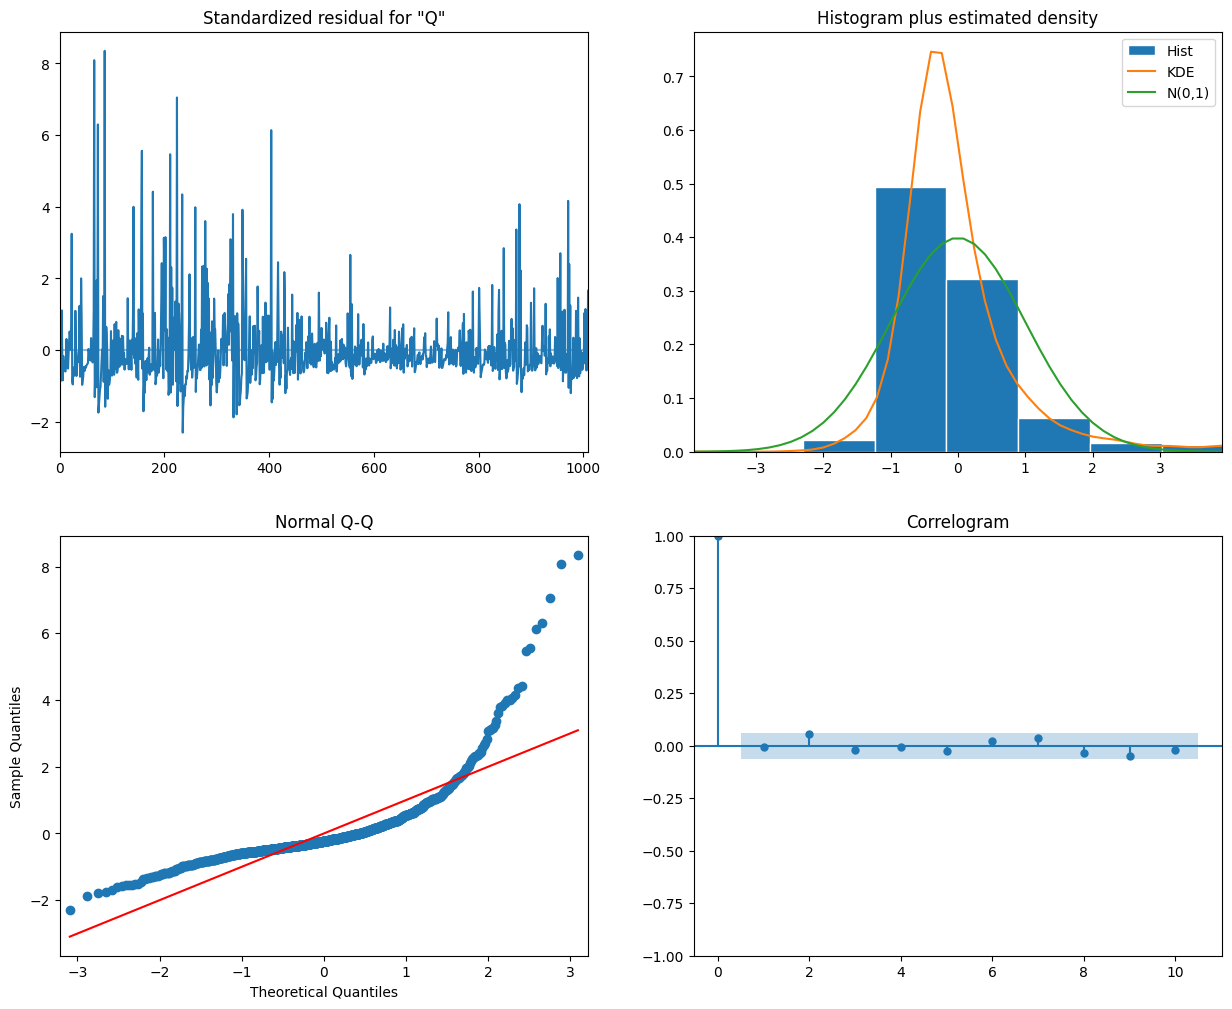

1010    723.168278
1011    719.502829
1012    715.993244
1013    712.632895
1014    709.415437
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [39]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit an ARIMA model (example with order (1,0,1))
model = ARIMA(shampoo_daily, order=(1, 0, 1))
model_fit = model.fit()

# Model Diagnostics
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

# Make Forecast
forecast = model_fit.forecast(steps=5)  # Forecast next 5 periods
print(forecast)

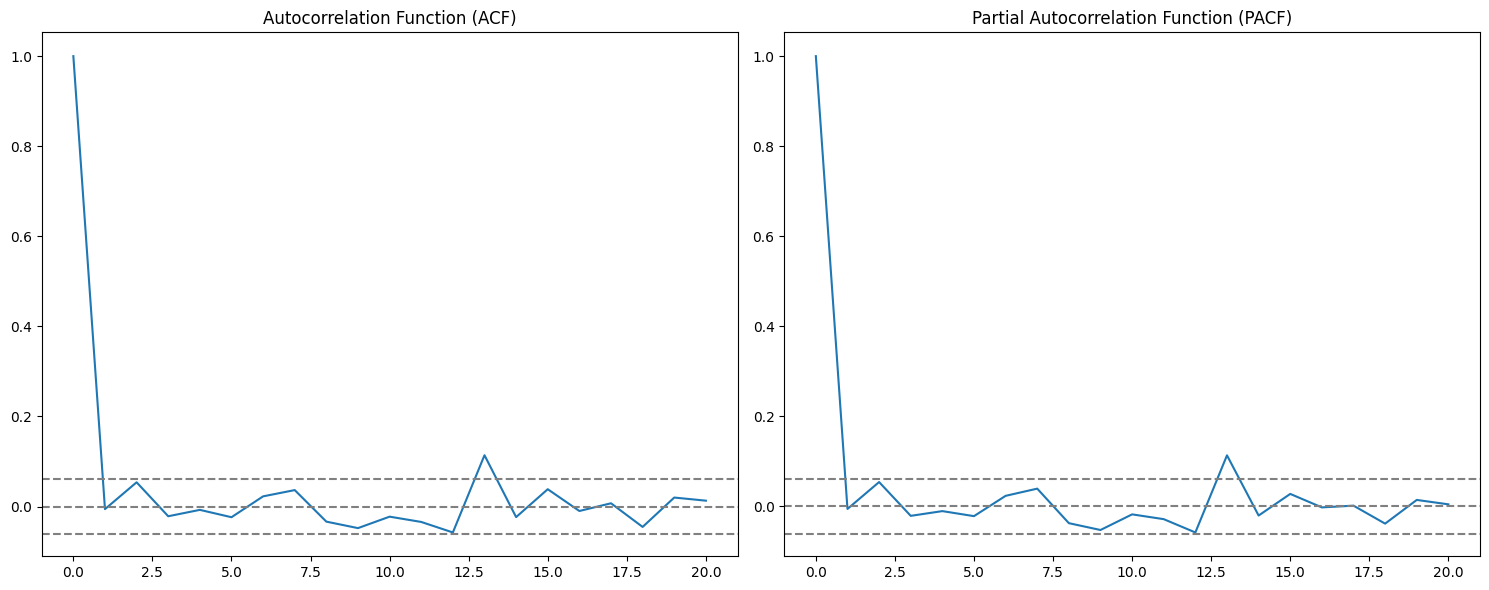

In [40]:
from statsmodels.tsa.stattools import acf, pacf

# Calculate the ACF and PACF
lag_acf = acf(model_fit.resid, nlags=20)
lag_pacf = pacf(model_fit.resid, nlags=20, method='ols')

# Plot ACF and PACF
plt.figure(figsize=(15, 6))

# ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(shampoo_daily)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(shampoo_daily)), linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF)')

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(shampoo_daily)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(shampoo_daily)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()


In [41]:
 pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.5 MB/s eta 0:00:00


In [42]:
from pmdarima import auto_arima
import pandas as pd

# Assuming shampoo_daily is your time series DataFrame for 'shampoo' product_type

# Running auto_arima to find the best ARIMA model parameters
auto_arima_model = auto_arima(shampoo_daily, start_p=0, start_q=0,
                              test='adf',       # Use adftest to find optimal 'd'
                              max_p=5, max_q=5, # Maximum p and q
                              m=1,              # Frequency of the series
                              d=None,           # Let model determine 'd'
                              seasonal=False,   # No Seasonality
                              start_P=0,
                              D=0,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

print(auto_arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16974.774, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=16704.156, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=16822.202, Time=0.34 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=16567.056, Time=0.13 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=16528.365, Time=0.13 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=16501.746, Time=0.15 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=16487.281, Time=0.14 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=16417.386, Time=1.18 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=16415.637, Time=1.54 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=16413.950, Time=2.94 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=16423.439, Time=2.40 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=16411.588, Time=4.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=16425.032, Time=3.12 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=16416.644, Time=3.64 sec
 ARIMA(3,0,3)(0,0,0

In [43]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model without the non-significant term
model = ARIMA(shampoo_daily, order=(2, 0, 2))
model_fit = model.fit()

# Display the model summary
print(model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    QTY   No. Observations:                 1010
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -8201.234
Date:                Sat, 02 Dec 2023   AIC                          16414.468
Time:                        12:11:20   BIC                          16443.974
Sample:                             0   HQIC                         16425.677
                               - 1010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        636.8849    149.846      4.250      0.000     343.193     930.577
ar.L1         -0.0126      0.063     -0.200      0.842      -0.136       0.111
ar.L2          0.9300      0.061     15.196      0.0

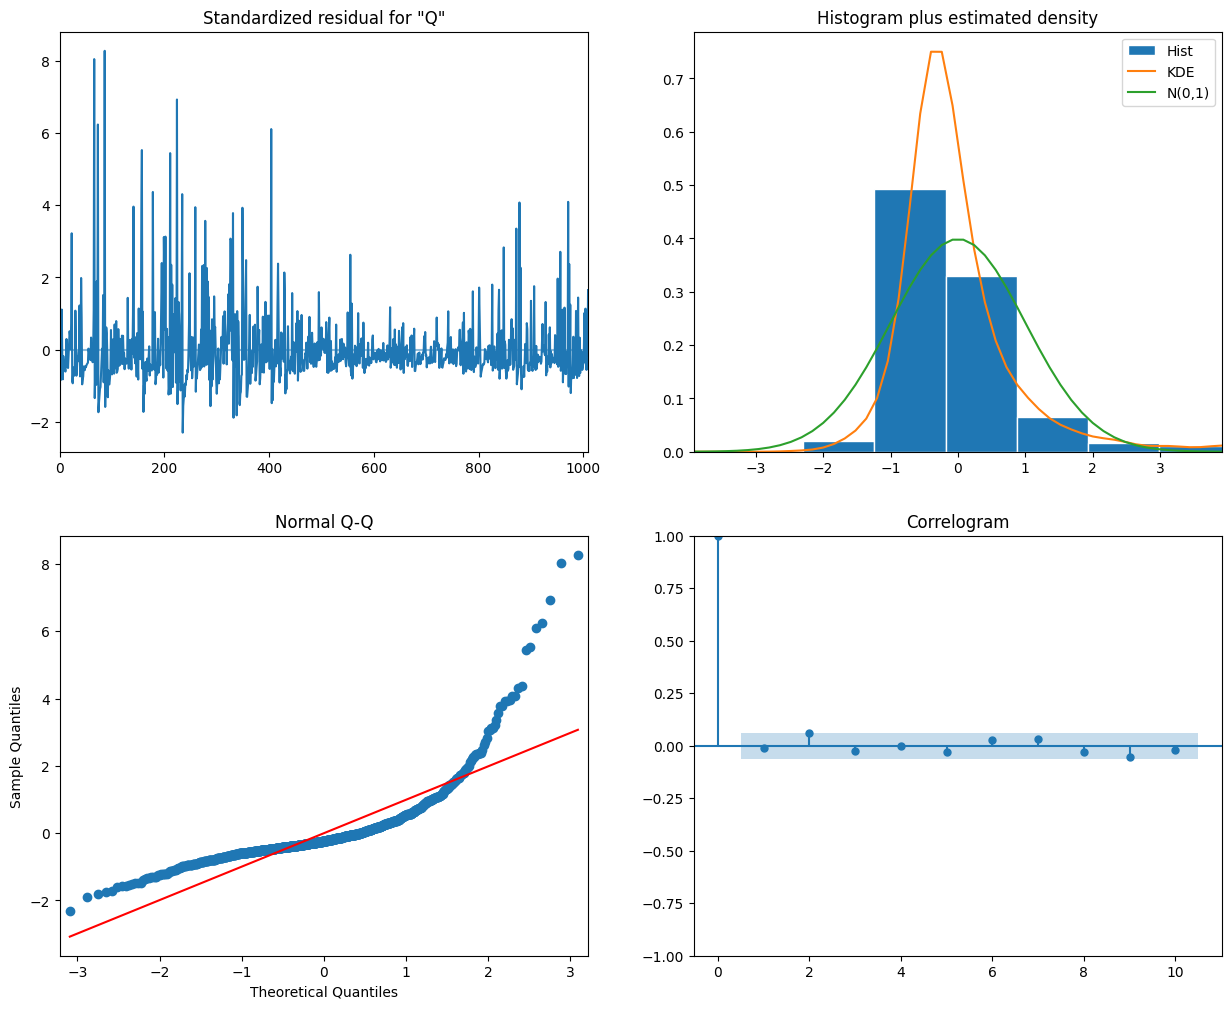

In [44]:
# Model Diagnostics
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

                               SARIMAX Results                                
Dep. Variable:                    QTY   No. Observations:                 1010
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -7857.754
Date:                Sat, 02 Dec 2023   AIC                          15729.508
Time:                        12:11:25   BIC                          15763.931
Sample:                             0   HQIC                         15742.585
                               - 1010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        544.2690     92.259      5.899      0.000     363.444     725.094
Outlier     4067.0860     57.991     70.133      0.000    3953.426    4180.746
ar.L1          0.0962      0.401      0.240      0.8

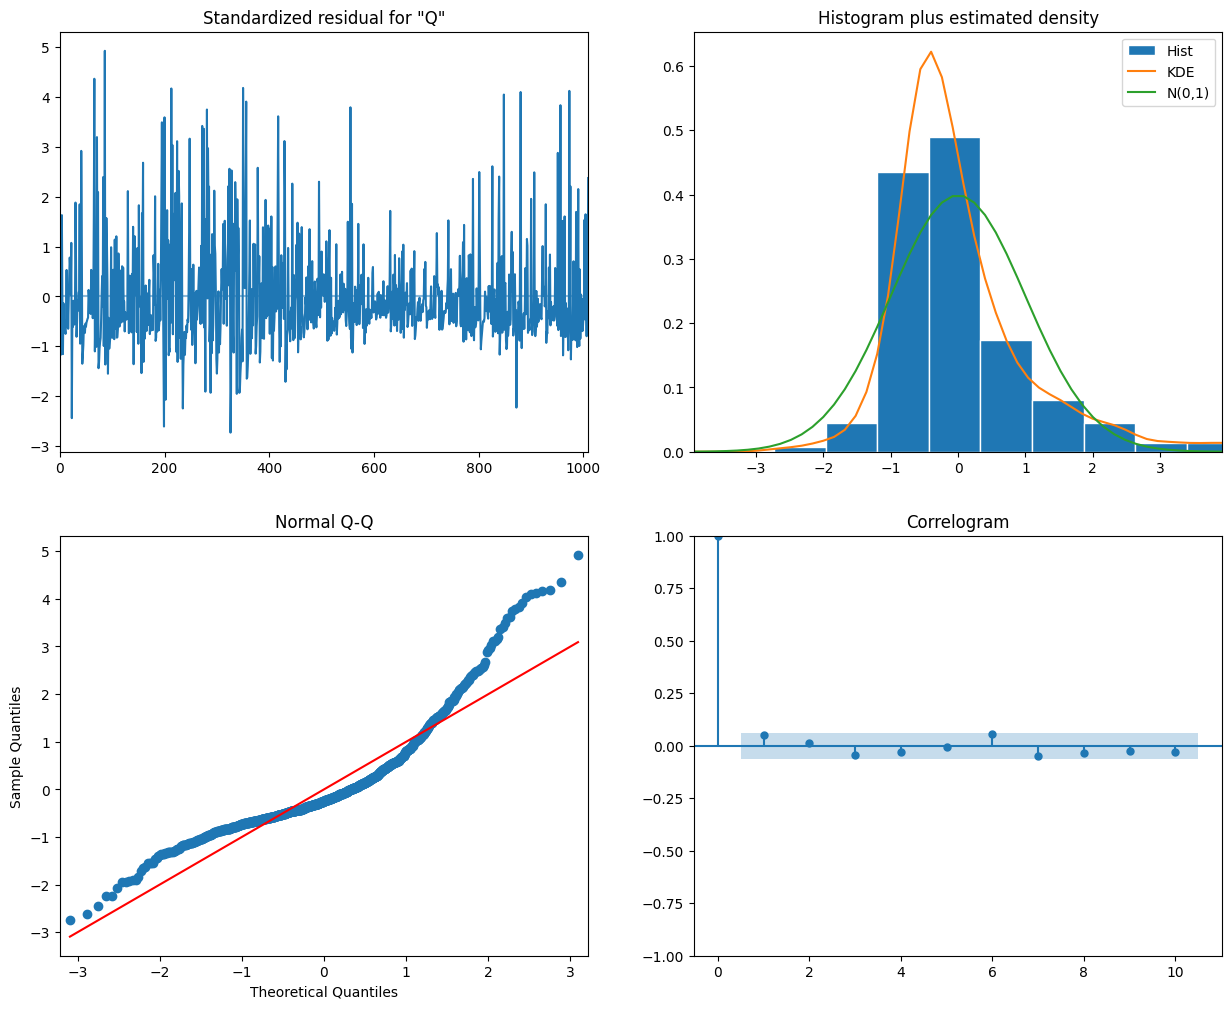

In [45]:
# Assuming 'shampoo_daily' is your Pandas Series of summed 'QTY'
shampoo_daily_df = shampoo_daily.to_frame(name='QTY')

# Ensure that 'QTY' is numeric and has no missing values
shampoo_daily_df['QTY'] = pd.to_numeric(shampoo_daily_df['QTY'], errors='coerce').fillna(0)

# Calculate the standard deviation of the residuals
residuals_std = np.std(model_fit.resid)

# Generate a boolean Series for outliers from the residuals
is_outlier = (model_fit.resid > 3 * residuals_std) | (model_fit.resid < -3 * residuals_std)

# Ensure the boolean Series for outliers is aligned with the shampoo_daily_df index
# The residuals are aligned with the model's fitted values, which correspond to the original Series' index
is_outlier_aligned = pd.Series(is_outlier, index=shampoo_daily_df.index)

# Fill NaN values with 0 for the outlier column
is_outlier_aligned_filled = is_outlier_aligned.fillna(0)

# Add the outlier information as a new column in the DataFrame
shampoo_daily_df['Outlier'] = is_outlier_aligned_filled.astype(int)

# Fit the ARIMA model with the 'Outlier' column as an exogenous variable
model_with_dummy = ARIMA(shampoo_daily_df['QTY'], exog=shampoo_daily_df[['Outlier']], order=(2, 0, 2))
model_with_dummy_fit = model_with_dummy.fit()

# Print the summary of the new model
print(model_with_dummy_fit.summary())

# Plot the diagnostics for the new model
model_with_dummy_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


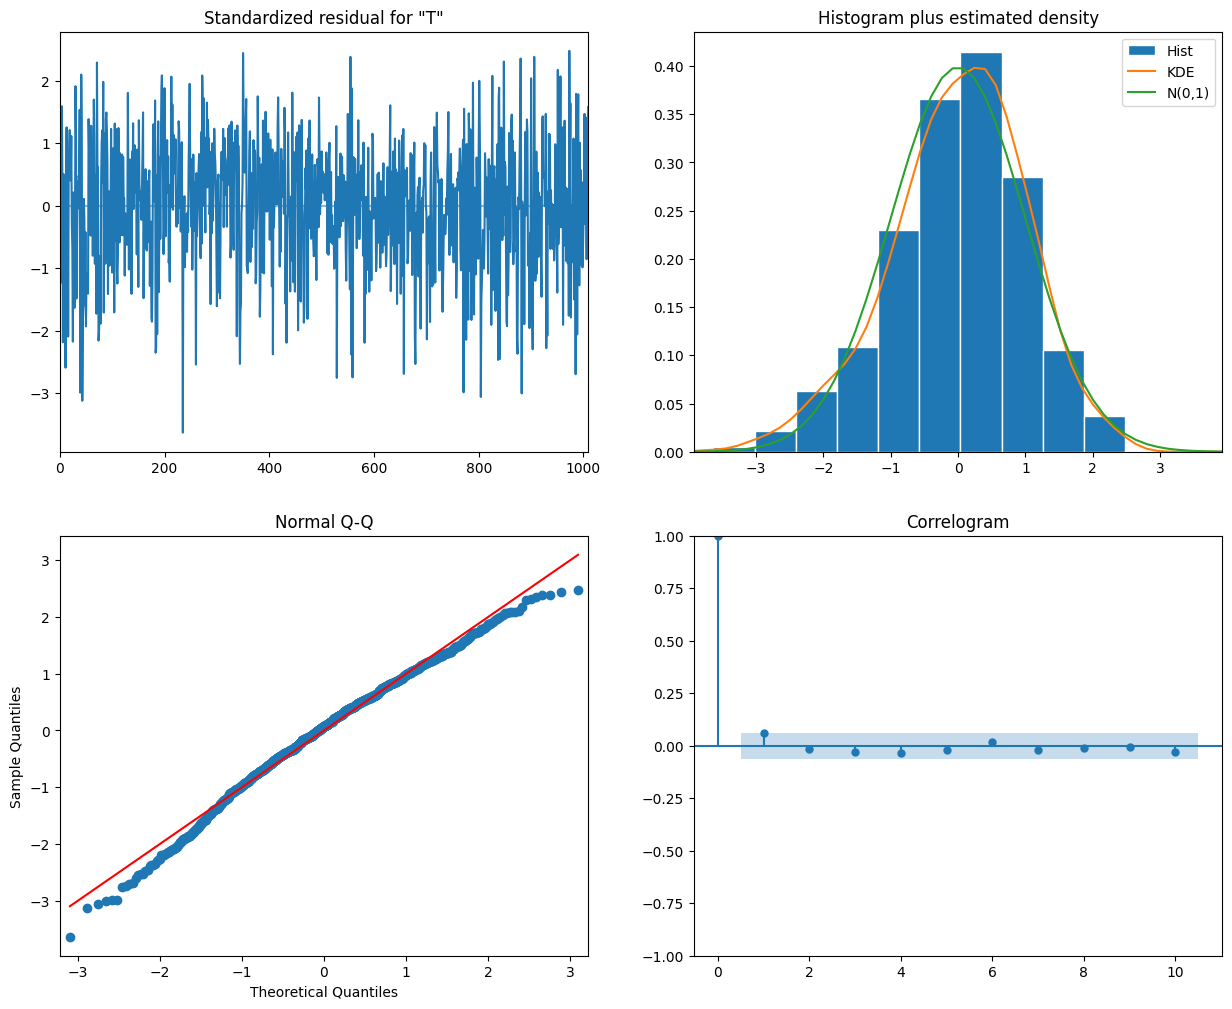

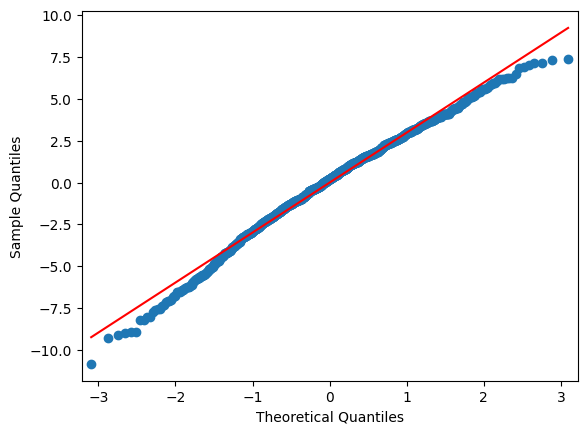

In [46]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
from statsmodels.graphics.gofplots import qqplot
import pandas as pd

# Assuming shampoo_daily_df['QTY'] and shampoo_daily_df['Outlier'] are correctly set

# Ensure all values are positive for Box-Cox Transformation
constant_to_add = abs(min(shampoo_daily_df['QTY'])) + 1
shampoo_daily_positive = shampoo_daily_df['QTY'] + constant_to_add

# Apply Box-Cox Transformation to the positive values
shampoo_daily_transformed, lambda_value = boxcox(shampoo_daily_positive)

# Create a new DataFrame for modeling which aligns the transformed data with the exogenous variable
modeling_df = pd.DataFrame({
    'Transformed_QTY': shampoo_daily_transformed,
    'Outlier': shampoo_daily_df['Outlier']
})

# Fit the ARIMA model on the transformed data
model_with_dummy_transformed = ARIMA(modeling_df['Transformed_QTY'], exog=modeling_df['Outlier'], order=(2, 0, 2))
model_with_dummy_fit_transformed = model_with_dummy_transformed.fit()

# Plot the diagnostics for the new model
model_with_dummy_fit_transformed.plot_diagnostics(figsize=(15, 12))
plt.show()

# Use qqplot to check normality visually
qqplot(model_with_dummy_fit_transformed.resid, line='s')
plt.show()


In [58]:
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error
import numpy as np

split_date = pd.to_datetime('2022-01-01')


train_data_transformed = modeling_df[modeling_df.index <= split_date]
test_data_transformed = modeling_df[modeling_df.index > split_date]

# Fit the ARIMA model on the transformed train data
train_model_transformed = ARIMA(train_data_transformed['Transformed_QTY'], exog=train_data_transformed['Outlier'], order=(2, 0, 2))
train_model_fit_transformed = train_model_transformed.fit()

# Forecast on the transformed test data
forecast_transformed = train_model_fit_transformed.forecast(steps=len(test_data_transformed), exog=test_data_transformed['Outlier'])

# Inverse Box-Cox Transformation on forecast and actual test data
forecast_original_scale = inv_boxcox(forecast_transformed, lambda_value)
actual_original_scale = inv_boxcox(test_data_transformed['Transformed_QTY'], lambda_value)

# Calculate RMSE
mse = mean_squared_error(actual_original_scale, forecast_original_scale)
rmse = np.sqrt(mse)
print(f'Test RMSE: {rmse:.3f}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

Test RMSE: 443.631


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [48]:
# Calculate the mean of the original sales data
mean_original_data = shampoo_daily_df['QTY'].mean()
print(f'Mean of Original Sales Data: {mean_original_data:.3f}')

Mean of Original Sales Data: 636.884


In [49]:
# from scipy.special import inv_boxcox
# from sklearn.metrics import mean_squared_error

# # Split the transformed data into train and test sets
# train_data_transformed = shampoo_daily_transformed[shampoo_daily_df.index <= '2022-01-01']
# test_data_transformed = shampoo_daily_transformed[shampoo_daily_df.index > '2022-01-01']

# # Fit the ARIMA model on the transformed train data
# model_transformed = ARIMA(train_data_transformed, order=(2, 0, 2))
# model_fit_transformed = model_transformed.fit()

# # Forecast on the transformed test data
# forecast_transformed = model_fit_transformed.forecast(steps=len(test_data_transformed))

# # Inverse Box-Cox Transformation on forecast and actual test data
# forecast = inv_boxcox(forecast_transformed, lambda_value)
# actual = inv_boxcox(test_data_transformed, lambda_value)

# # Calculate RMSE
# mse = mean_squared_error(actual, forecast)
# rmse = np.sqrt(mse)
# print(f'Test RMSE: {rmse:.3f}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test RMSE: 522.297


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    QTY   No. Observations:                  717
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -5616.851
Date:                Sat, 02 Dec 2023   AIC                          11245.702
Time:                        12:19:13   BIC                          11273.153
Sample:                             0   HQIC                         11256.302
                                - 717                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        536.5570    144.942      3.702      0.000     252.477     820.637
ar.L1          0.2075      0.282      0.735      0.462      -0.346       0.761
ar.L2          0.7327      0.273      2.680      0.0

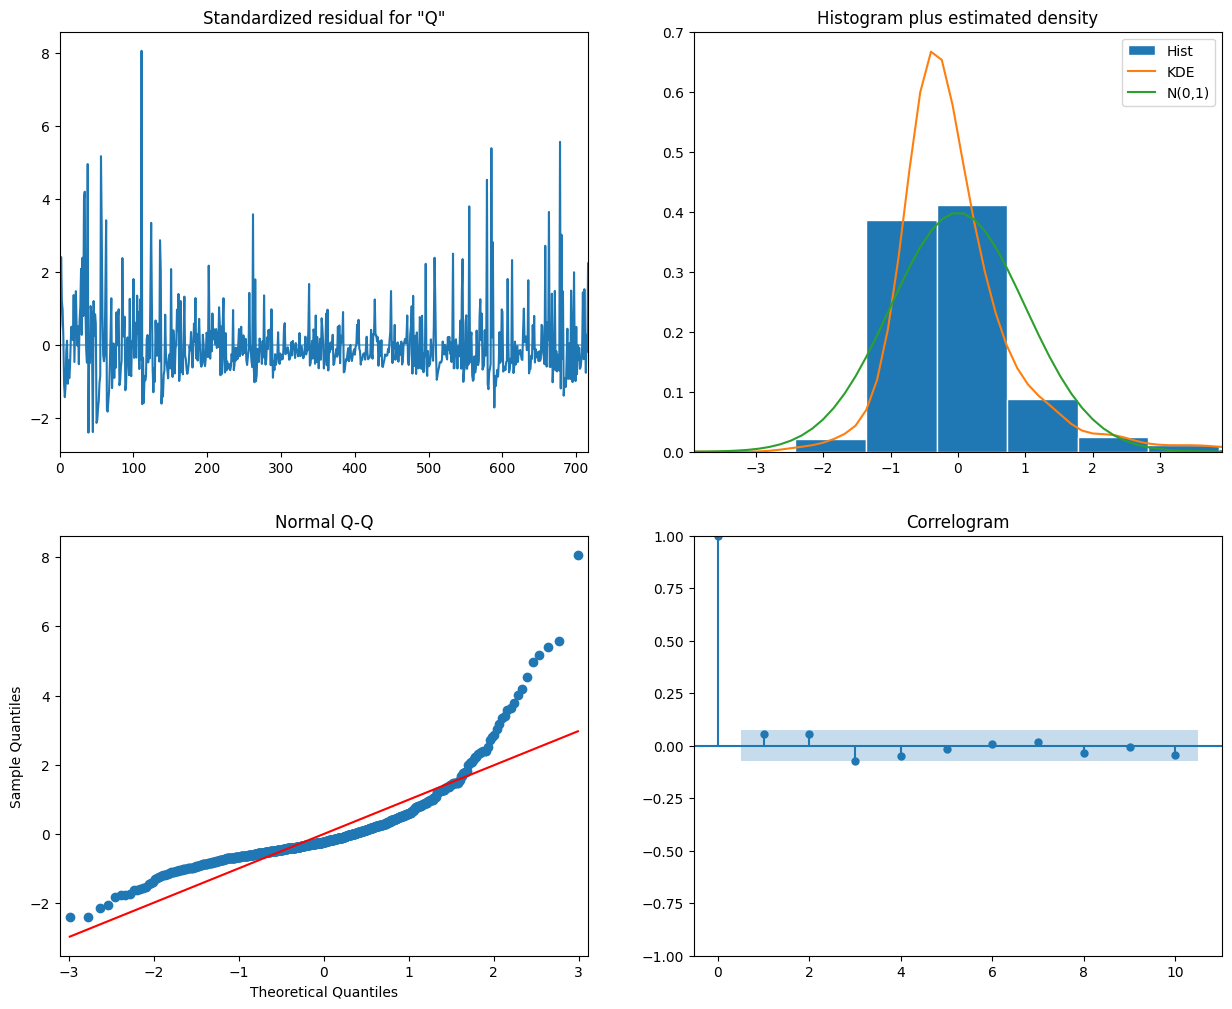

In [50]:
# Convert the index to datetime if it's not already
shampoo_daily_df.index = pd.to_datetime(shampoo_daily_df.index)

# Define the end date for the COVID period
covid_end = pd.to_datetime('2021-01-07')

# Filter the DataFrame to only include data after the COVID period
shampoo_daily_post_covid = shampoo_daily_df[shampoo_daily_df.index > covid_end]

# Since we are only using data after the COVID period, we don't need a Covid_Period dummy variable
# Now fit the ARIMA model on this filtered data
model_post_covid = ARIMA(shampoo_daily_post_covid['QTY'], order=(2, 0, 2))
model_post_covid_fit = model_post_covid.fit()

# Print the summary of the new model
print(model_post_covid_fit.summary())

# Plot the diagnostics for the new model
model_post_covid_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    QTY   No. Observations:                  578
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -4400.431
Date:                Sat, 02 Dec 2023   AIC                           8812.863
Time:                        12:19:18   BIC                           8839.020
Sample:                             0   HQIC                          8823.062
                                - 578                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        413.8726     67.989      6.087      0.000     280.617     547.128
ar.L1          0.3165      0.305      1.039      0.299      -0.281       0.914
ar.L2          0.6098      0.296      2.059      0.0

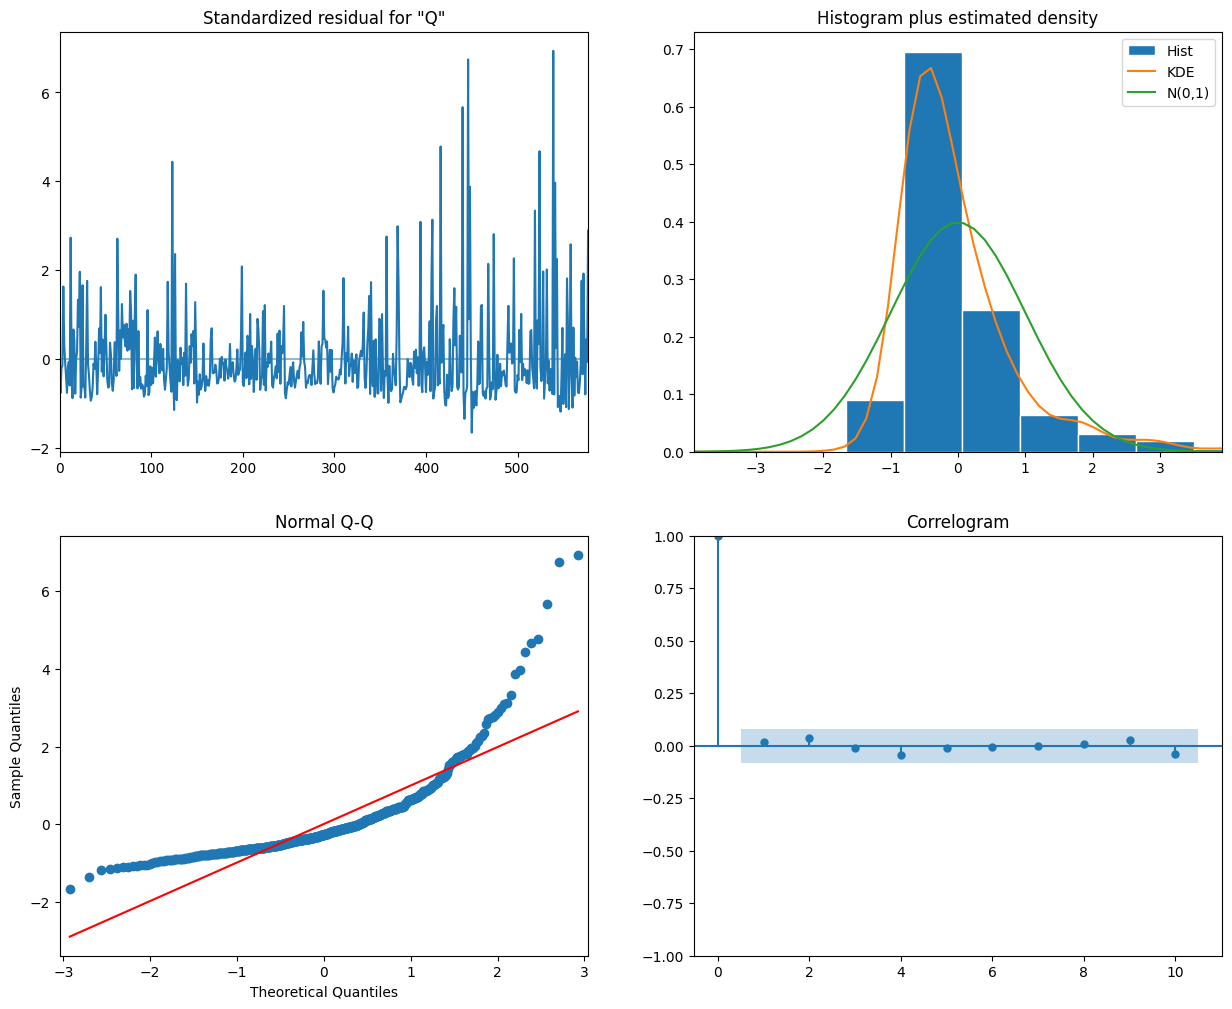

In [51]:
# Ensure the DataFrame index is of type DatetimeIndex
shampoo_daily_df.index = pd.to_datetime(shampoo_daily_df.index, errors='coerce')

# Now that we've ensured the index is datetime, filter out the COVID-19 period.
# We'll use the period after July 2021 for the ARIMA model fitting.
post_covid_data = shampoo_daily_df.loc[shampoo_daily_df.index > '2021-07-01']

# Make sure that 'QTY' is the correct column name for your sales data.
# Fit the ARIMA model using the post-COVID-19 data.
model_post_covid = ARIMA(post_covid_data['QTY'], order=(2, 0, 2))
model_post_covid_fit = model_post_covid.fit()

# Print the summary of the new model.
print(model_post_covid_fit.summary())

# Plot the diagnostics for the new model.
model_post_covid_fit.plot_diagnostics(figsize=(15, 12))
plt.show()


In [52]:
# Assuming you've already fitted your model: model_fit
# Assuming your DataFrame is shampoo_daily_df and the date index is already converted to datetime
shampoo_daily_df.index = pd.DatetimeIndex(shampoo_daily_df.index).to_period('D')

# Split data into train and test
train_data = shampoo_daily_df[shampoo_daily_df.index <= '2022-01-01']  # Example end of training period
test_data = shampoo_daily_df[shampoo_daily_df.index > '2022-01-01']   # Example start of testing period

# Fit the model on train_data
train_model = ARIMA(train_data['QTY'], order=(2, 0, 2))
train_model_fit = train_model.fit()

# Forecast on test_data
forecast = train_model_fit.forecast(steps=len(test_data))

# Compare the forecast to the actual values
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_data['QTY'], forecast)
rmse = np.sqrt(mse)
print(f'Test RMSE: {rmse:.3f}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test RMSE: 668.499


In [53]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Assuming shampoo_daily_df is already correctly indexed with PeriodIndex

# Split data into train and test
train_data = shampoo_daily_df[shampoo_daily_df.index <= '2022-01-01']  # Example end of training period
test_data = shampoo_daily_df[shampoo_daily_df.index > '2022-01-01']   # Example start of testing period

# Fit the model on train_data
train_model = ARIMA(train_data['QTY'], order=(2, 0, 2))
train_model_fit = train_model.fit()

# Forecast on test_data
forecast = train_model_fit.forecast(steps=len(test_data))

# Compare the forecast to the actual values
mse = mean_squared_error(test_data['QTY'], forecast)
rmse = np.sqrt(mse)
print(f'Test RMSE: {rmse:.3f}')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Test RMSE: 668.499


In [54]:
import numpy as np

# Assuming shampoo_daily_df is your DataFrame and 'QTY' is the column with sales data

# Calculate the range of the sales data
data_range = shampoo_daily_df['QTY'].max() - shampoo_daily_df['QTY'].min()
data_mean = shampoo_daily_df['QTY'].mean()
print(f"Data Mean: {data_mean}")
print(f"Data Range: {data_range}")

# Calculate the standard deviation of the sales data
data_std = shampoo_daily_df['QTY'].std()
print(f"Data Standard Deviation: {data_std}")

# Given RMSE value
rmse = 668.499
print(f"Test RMSE: {rmse}")

# Compare RMSE to data range and standard deviation
print(f"RMSE is {'smaller' if rmse < data_range else 'larger'} than the range of the data.")
print(f"RMSE is {'smaller' if rmse < data_std else 'larger'} than the standard deviation of the data.")


Data Mean: 636.8841584158416
Data Range: 7454
Data Standard Deviation: 870.9310907090536
Test RMSE: 668.499
RMSE is smaller than the range of the data.
RMSE is smaller than the standard deviation of the data.


In [55]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# # Assuming your DataFrame is shampoo_daily_df and the date index is already converted to datetime
# shampoo_daily_df.index = pd.DatetimeIndex(shampoo_daily_df.index).to_period('D')

# Filter the DataFrame to only include data after the COVID period (after July 2021)
shampoo_daily_post_covid = shampoo_daily_df[shampoo_daily_df.index > '2021-07']

# Split the post-COVID data into train and test sets
# For example, let's take a split date, you can adjust this as needed
split_date = pd.to_datetime('2022-01-01').to_period('D')
train_data = shampoo_daily_post_covid[shampoo_daily_post_covid.index <= split_date]
test_data = shampoo_daily_post_covid[shampoo_daily_post_covid.index > split_date]

# Fit the model on train_data
train_model = ARIMA(train_data['QTY'], order=(2, 0, 2))
train_model_fit = train_model.fit()

# Forecast on test_data
forecast = train_model_fit.forecast(steps=len(test_data))

# Compare the forecast to the actual values
mse = mean_squared_error(test_data['QTY'], forecast)
rmse = np.sqrt(mse)
print(f'Test RMSE: {rmse:.3f}')


Test RMSE: 527.942


In [ ]:
test_data['QTY'].mean()

##LSTM Forecasting

In [ ]:
rate_df = pd.read_csv("/content/drive/MyDrive/Capstone/usd-lbp.csv")

In [ ]:
# Assuming your DataFrame is named rate_df
rate_df = rate_df.rename(columns={'DateTime': 'Document Date'})

In [ ]:
# Convert the date columns to datetime if they are not already
df['Document Date'] = pd.to_datetime(df['Document Date'])
rate_df['Document Date'] = pd.to_datetime(rate_df['Document Date'])

# Merge the DataFrames based on the 'Date' column
# 'how' parameter can be adjusted based on how you want to handle unmatched dates
merged_df = pd.merge(df, rate_df, on='Document Date', how='left')

# Handle missing values in the exchange rate, if necessary
merged_df['USD to LBP'].fillna(method='ffill', inplace=True)
df = merged_df

In [ ]:
df.columns

In [ ]:
distinct_sizes = shampoo_df['product_size'].unique()

print("Distinct product sizes for 'shampoo':", distinct_sizes)

In [1]:
df.to_csv("with_rate.csv", index = False)

NameError: ignored

In [84]:
shampoo_df = df[df['product_type'] == 'shampoo']

# Count the number of shampoos for each size
shampoo_counts_by_size = shampoo_df['product_size'].value_counts()

print("Count of shampoos for each size:")
print(shampoo_counts_by_size)

Count of shampoos for each size:
4.0L      12390
1.125L     7146
2.25L      6880
0.022L     3096
0.225L     2959
3.0L       2814
6.0L       2343
0.011L     2108
1.5L       1604
0.112L     1591
0nan        919
2.0L        571
2.2L        192
0.4L        182
0.04L       176
4.2L         83
1.1L         61
0.008L       46
1.0L         34
0.5L         31
0.01L        11
Name: product_size, dtype: int64


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(shampoo_daily_df[['QTY']].values)

# Split into train and test sets
# Assume split_date is defined as before
train_data_scaled = scaled_data[shampoo_daily_df.index <= split_date]
test_data_scaled = scaled_data[shampoo_daily_df.index > split_date]

# Reshape data for LSTM [samples, timesteps, features]
# This is a simplified example; you might need to adjust the reshaping based on your data
# Assuming using previous day's data to predict next day

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, Y_train = create_dataset(train_data_scaled, look_back)
X_test, Y_test = create_dataset(test_data_scaled, look_back)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))

# Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, epochs=100, batch_size=1, verbose=2)

# Making predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

# Calculate RMSE for LSTM predictions
lstm_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0]))
print(f'LSTM Test RMSE: {lstm_rmse:.3f}')


Epoch 1/100
581/581 - 3s - loss: 0.0191 - 3s/epoch - 5ms/step
Epoch 2/100
581/581 - 1s - loss: 0.0185 - 1s/epoch - 2ms/step
Epoch 3/100
581/581 - 1s - loss: 0.0184 - 1s/epoch - 2ms/step
Epoch 4/100
581/581 - 1s - loss: 0.0179 - 1s/epoch - 2ms/step
Epoch 5/100
581/581 - 1s - loss: 0.0183 - 1s/epoch - 2ms/step
Epoch 6/100
581/581 - 1s - loss: 0.0182 - 1s/epoch - 2ms/step
Epoch 7/100
581/581 - 1s - loss: 0.0182 - 1s/epoch - 2ms/step
Epoch 8/100
581/581 - 1s - loss: 0.0183 - 1s/epoch - 2ms/step
Epoch 9/100
581/581 - 1s - loss: 0.0182 - 1s/epoch - 2ms/step
Epoch 10/100
581/581 - 1s - loss: 0.0182 - 1s/epoch - 2ms/step
Epoch 11/100
581/581 - 1s - loss: 0.0181 - 1s/epoch - 2ms/step
Epoch 12/100
581/581 - 1s - loss: 0.0181 - 1s/epoch - 2ms/step
Epoch 13/100
581/581 - 1s - loss: 0.0181 - 1s/epoch - 2ms/step
Epoch 14/100
581/581 - 1s - loss: 0.0181 - 1s/epoch - 2ms/step
Epoch 15/100
581/581 - 1s - loss: 0.0180 - 1s/epoch - 2ms/step
Epoch 16/100
581/581 - 1s - loss: 0.0180 - 1s/epoch - 2ms/step
E